#ML for business 2-Clustering

#Imports

In [147]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['ylim', 'arrow', 'annotate', 'xlim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [148]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotnine
from plotnine import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [149]:
!pip install prince

In [150]:
import prince

In [151]:
!pip install kmodes

In [152]:
from kmodes.kprototypes import KPrototypes

#0. Data importation 




In [153]:
X = pd.read_csv("https://raw.githubusercontent.com/louis75020/ML-for-business/Clustering/german_credit_data.csv")
X.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [154]:
numerical = ['Credit amount','Age','Duration']
categorical = ['Sex','Job','Housing','Saving accounts','Checking account', 'Purpose']
unused = ['Unnamed: 0']
X = X.drop(labels=unused, axis='columns')

#Statistics

## Desciptive Statistics

In [ ]:
X.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


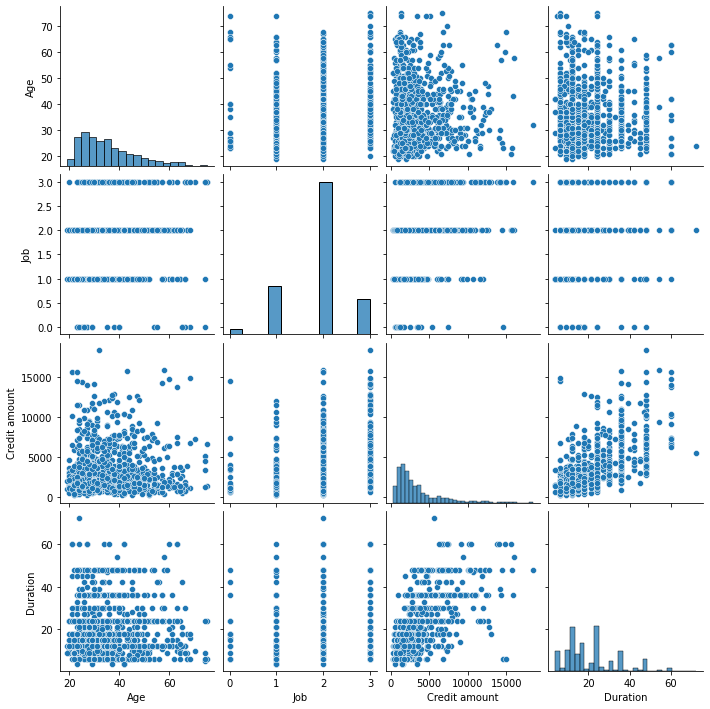

In [ ]:
sns.pairplot(X)

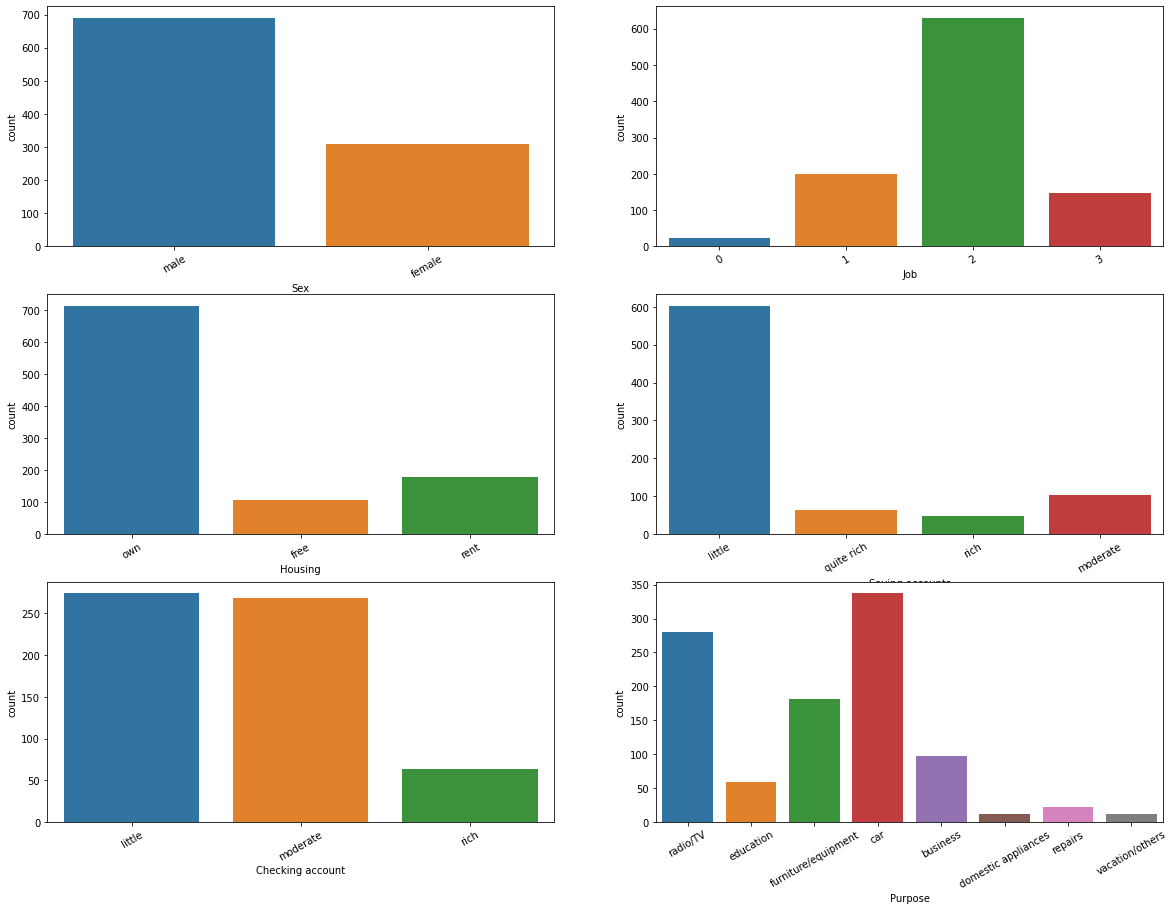

In [ ]:
fig = figure(figsize = (20,15))
axes = 320
for cat in categorical:
    axes += 1
    fig.add_subplot(axes)
    sns.countplot(data = X, x = cat)
    xticks(rotation=30)
show()

## Missing values

In [ ]:
X.isnull().sum(axis=0).reset_index()

,index,0
0,Age,0
1,Sex,0
2,Job,0
3,Housing,0
4,Saving accounts,183
5,Checking account,394
6,Credit amount,0
7,Duration,0
8,Purpose,0


In [ ]:
for cat in categorical: X[cat] = X[cat].fillna(X[cat].mode().values[0])

## Multivariate statistics

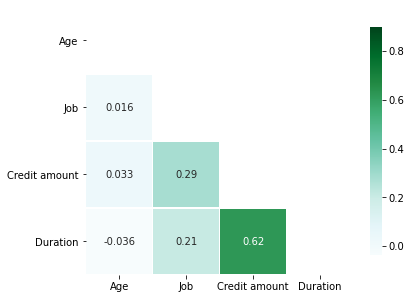

In [ ]:
corr = X.corr(method = 'pearson')
fig, ax = subplots(figsize = (6,6))
mask = triu(ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, vmax = 0.9, cmap='BuGn', square = True, annot = True, linewidths=.5, cbar_kws={"shrink": .7})

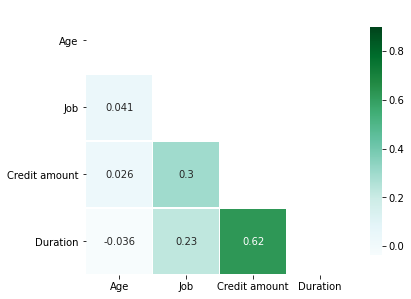

In [ ]:
corr = X.corr(method = 'spearman')
fig, ax = subplots(figsize = (6,6))
mask = triu(ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, vmax = 0.9, cmap='BuGn', square = True, annot = True, linewidths=.5, cbar_kws={"shrink": .7})

# Fast Elbow

In [127]:
class Elbow():

  def __init__(self, max_k):
    self.max_k = max_k

  def fit(self, X):
    self.explained_inertias = zeros(self.max_k - 1)
    for k in range(1, self.max_k):
      kmeans = KMeans(n_clusters = k, max_iter = 1000, n_init = 50, init = 'k-means++').fit(X)
      self.explained_inertias[k-1] = kmeans.inertia_

  def plot(self):
    figure()
    plot(range(1, self.max_k), self.explained_inertias)
    grid(True)
    title("Elbow's plot")
    xlabel("k")
    ylabel("Explained inertia")
    show()

# Visualizer

In [155]:
class Cluster_visualizer():

  
  def fit(self, X):

    self.pca = prince.PCA(
                  n_components=3,
                  n_iter=50,
                  rescale_with_mean=True,
                  rescale_with_std=True,
                  copy=True,
                  check_input=True,
                  engine='auto',
                  random_state=42
                  )
    self.pca.fit(X)
    self.X = X

  def plot_2d(self, y):

    figure()
    ax = self.pca.plot_row_coordinates(
        self.X,
        ax=None,
        figsize=(15, 15),
        x_component=0,
        y_component=1,
        color_labels = y,
        ellipse_outline=False,
        ellipse_fill=False,
        show_points=True
        )
    show(ax)

  def plot_3d(self, y):

    pca = self.pca; X = self.X
    XX = pca.transform(X).values

    fig = figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(XX[:, 0], XX[:, 1], XX[:, 2], c = y, cmap=cm.Set1, edgecolor='k',s=40)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector") 
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    ax.view_init(20, 60)
    show(ax)

  def plot_centers(self, centers):

    ax1 = self.pca.plot_row_coordinates(
    centers,
    ax=None,
    x_component=0,
    y_component=1,
    show_points=True
    )
    
    show(ax1)

In [166]:
def centroid_visualizer(X, y = None, numerical = [], categorical = [], type_categorical = 2, n_clusters = 4):

  if numerical == []: numerical = list(X.columns)

  if y != None: X['label'] = y

  for col in numerical :
    fig = figure(figsize = (10,10))
    sns.boxplot(
            x = 'label', 
            y = col, 
            data = X,
            whis=[0, 100], 
            width=.6, 
            palette="vlag")
    xticks(rotation=30)
    show(fig)

  if type_categorical == 1 and categorical != []:

      for col in categorical :

        print("################################")
        print(col)
        print("################################")

        figure( figsize = (20,20) )
        number = 221

        for i in range(n_clusters) : 
          subplot(number)
          sns.histplot(data = X.loc[X['label'] == i], x = col, discrete = True)
          title("Distribution of " + col + ' for label ' + str(i))
          number += 1
        show()
      
  if type_categorical == 2 and categorical != []:

      for col in categorical :

        print("################################")
        print(col)
        print("################################")

        figure( figsize = (10,10) )

        for i in range(n_clusters) :
          sns.histplot(data = X, x = col, hue = 'label', discrete = True, multiple='stack')
          title("Distribution of " + col + ' for label ' + str(i))
        show()

# 1. Get_dummies + KMEANS

In [28]:
X1 = X.copy()
X1 = pd.get_dummies(data = X1, columns = categorical, drop_first = True)
X1.head()

,Age,Credit amount,Duration,Sex_male,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1169,6,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,22,5951,48,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,49,2096,12,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,45,7882,42,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,53,4870,24,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


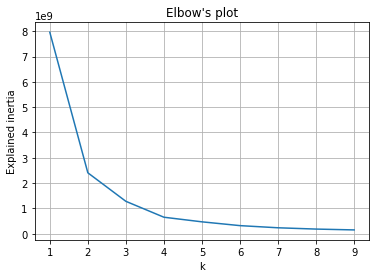

In [29]:
elbow = Elbow(max_k = 10)
elbow.fit(X1)
elbow.plot()

We wanna choose between 3 and 5 clusters : let's say 4.

In [30]:
kmeans1 = KMeans(n_clusters = 4, max_iter = 1000, n_init = 50, init = 'k-means++').fit(X1)

## PCA + plot

### 2d

<Figure size 432x288 with 0 Axes>

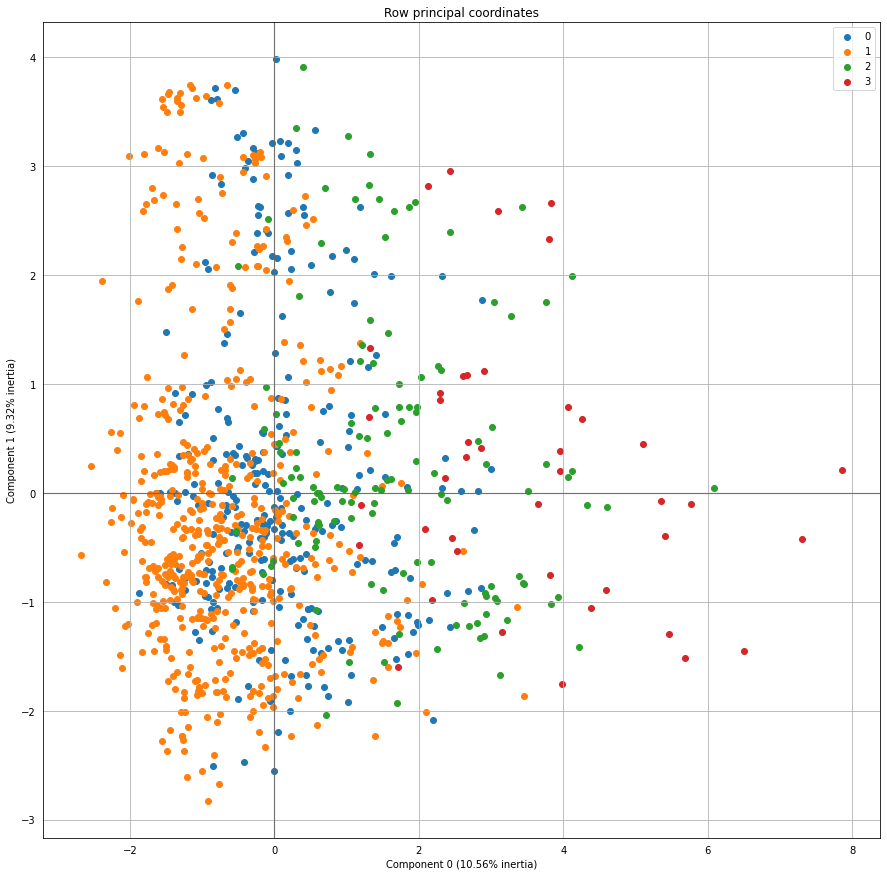

In [31]:
y1 = kmeans1.predict(X1)
visualizer = Cluster_visualizer()
visualizer.fit(X1)
visualizer.plot_2d(y1)

The clustering does not seem incredible, but only 20% of the total inertia has been explained by the PCA.

### 3d

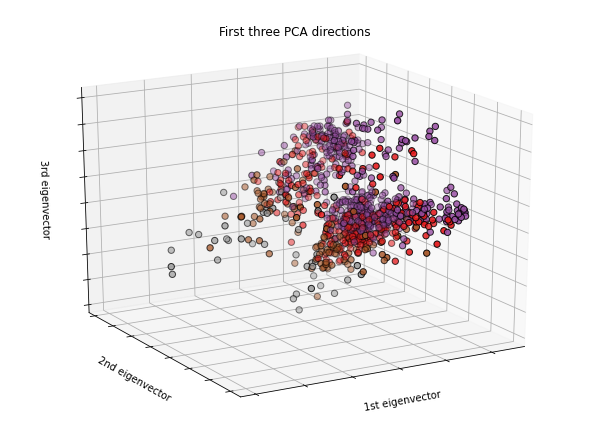

In [32]:
visualizer.plot_3d(y1)

## Centroids

No handles with labels found to put in legend.


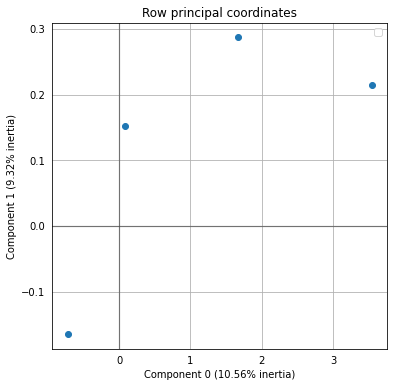

In [33]:
visualizer.plot_centers(kmeans1.cluster_centers_)

In [34]:
centers1 = pd.DataFrame(kmeans1.cluster_centers_)
centers1.columns = X1.columns
centers1

,Age,Credit amount,Duration,Sex_male,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,34.683099,3587.306338,23.492958,0.707746,0.165493,0.676056,0.144366,0.714789,0.186620,0.105634,0.066901,0.049296,0.253521,6.338028e-02,0.338028,7.042254e-03,0.024648,0.257042,0.235915,0.017606,0.003521
1,35.610294,1471.310662,15.082721,0.654412,0.253676,0.634191,0.084559,0.750000,0.180147,0.097426,0.073529,0.053309,0.244485,7.904412e-02,0.292279,1.838235e-02,0.073529,0.163603,0.347426,0.025735,0.005515
2,36.800000,7127.523077,33.346154,0.776923,0.084615,0.592308,0.307692,0.600000,0.176923,0.107692,0.015385,0.030769,0.330769,1.538462e-02,0.476923,-8.673617e-18,0.076923,0.123077,0.146154,0.015385,0.023077
3,36.666667,12511.714286,40.261905,0.761905,0.095238,0.380952,0.500000,0.571429,0.119048,0.142857,0.047619,0.023810,0.500000,-1.387779e-17,0.476190,-5.204170e-18,0.047619,0.071429,0.119048,0.023810,0.119048


get_dummies has not destroyed impretability of the k-means centers. What you see in the previous dataframe is the mean values of points belonging to the corresponding cluster. For example data in cluster 1 (line 0) have 3857 mean credit amount, and contains 70% of males while data in cluster 2 have a 1471 mean credit amount and only 65% men.

In [54]:
XX1 = X1.copy()
XX1['label'] = kmeans1.predict(XX1)
XX1

,Age,Credit amount,Duration,Sex_male,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,label
0,67,1169,6,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,22,5951,48,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,2
2,49,2096,12,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,45,7882,42,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2
4,53,4870,24,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1736,12,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
996,40,3857,30,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
997,38,804,12,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
998,23,1845,45,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


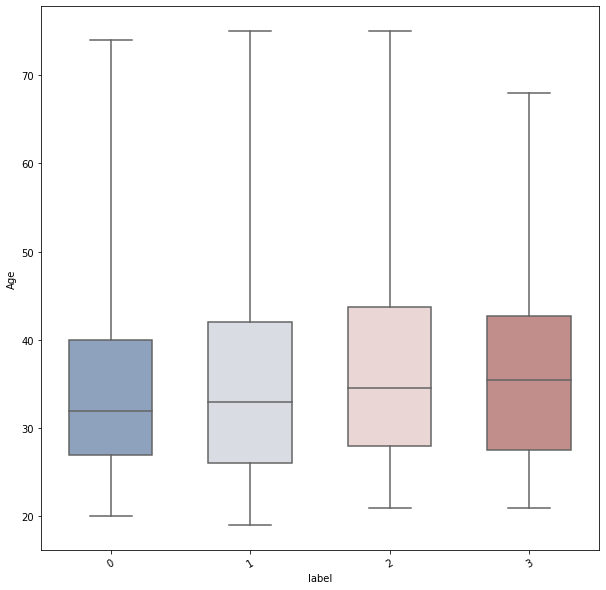

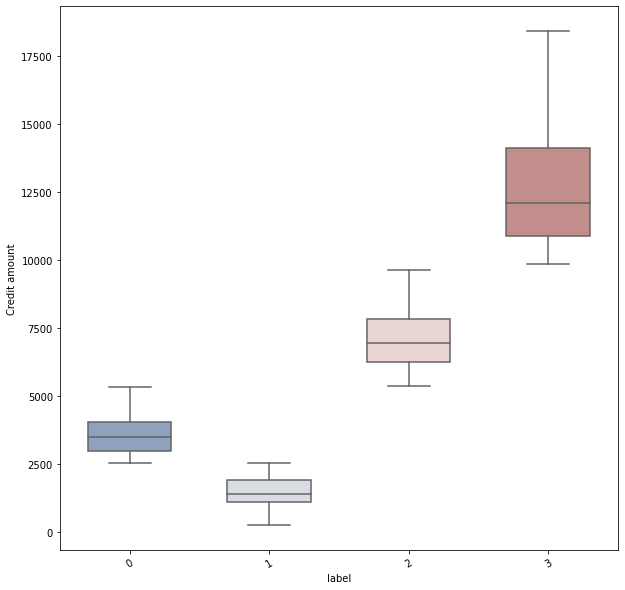

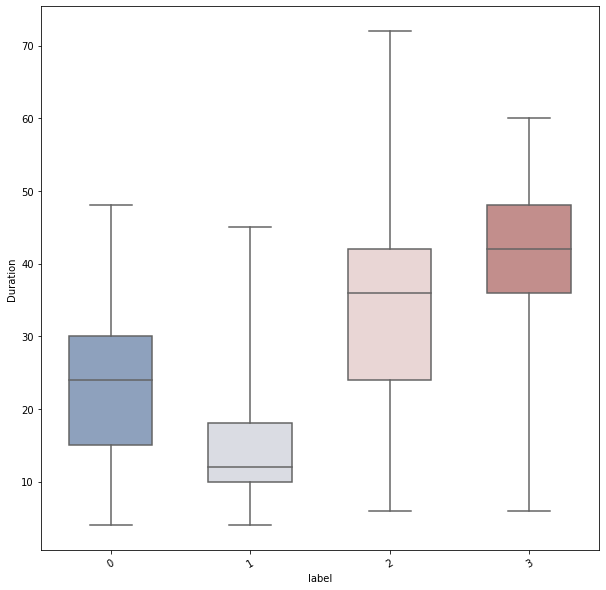

################################
Sex_male
################################


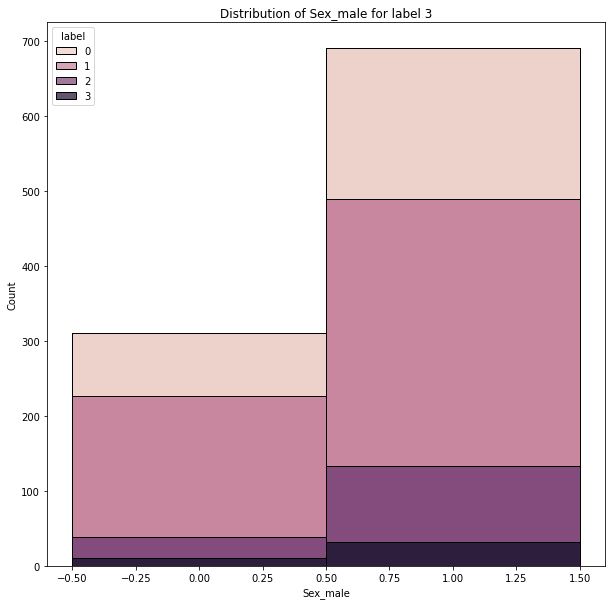

################################
Job_1
################################


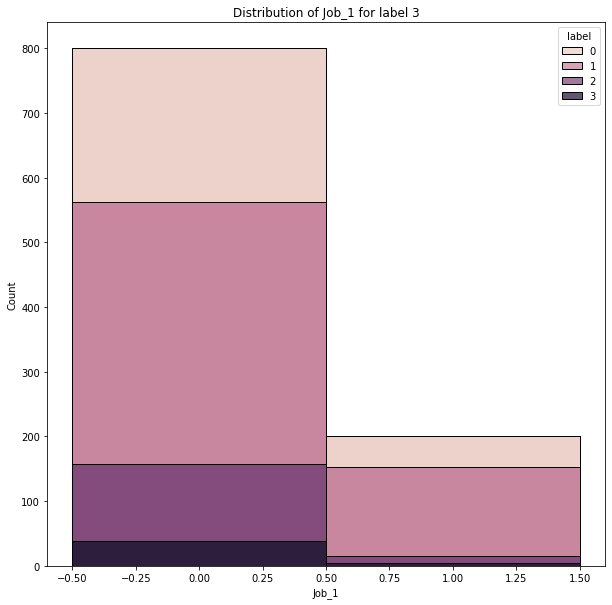

################################
Job_2
################################


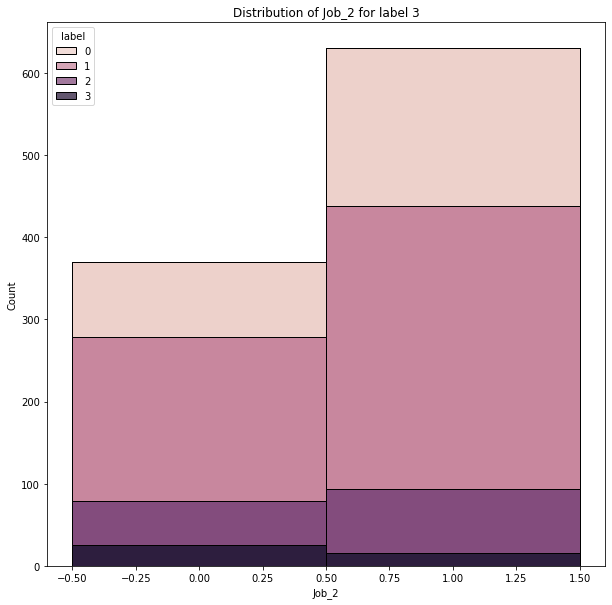

################################
Job_3
################################


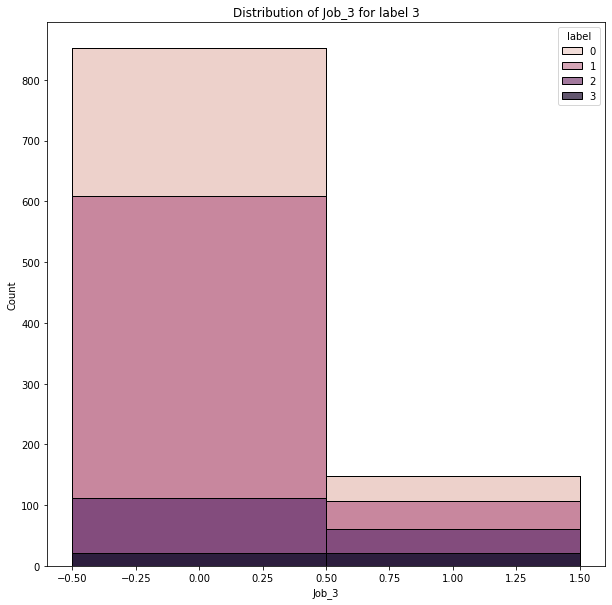

################################
Housing_own
################################


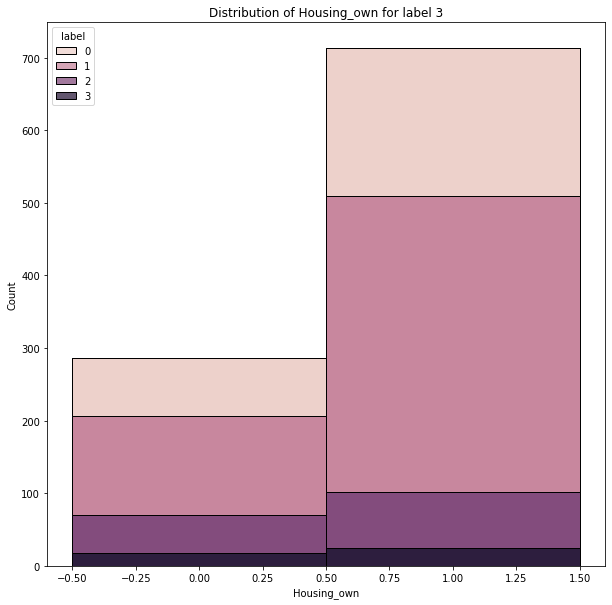

################################
Housing_rent
################################


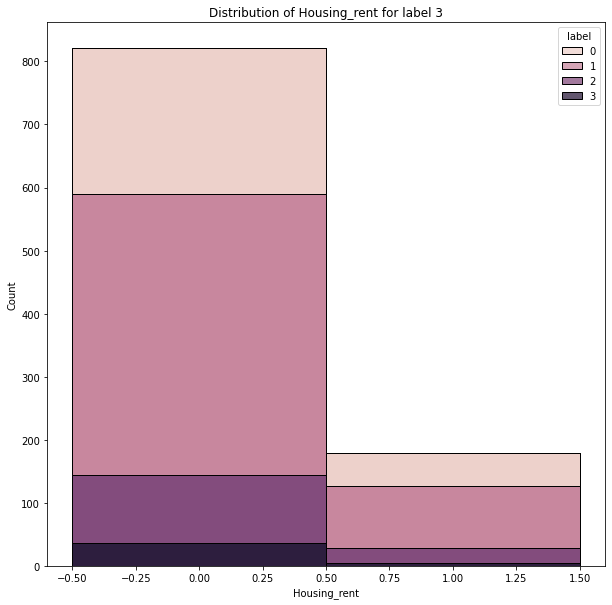

################################
Saving accounts_moderate
################################


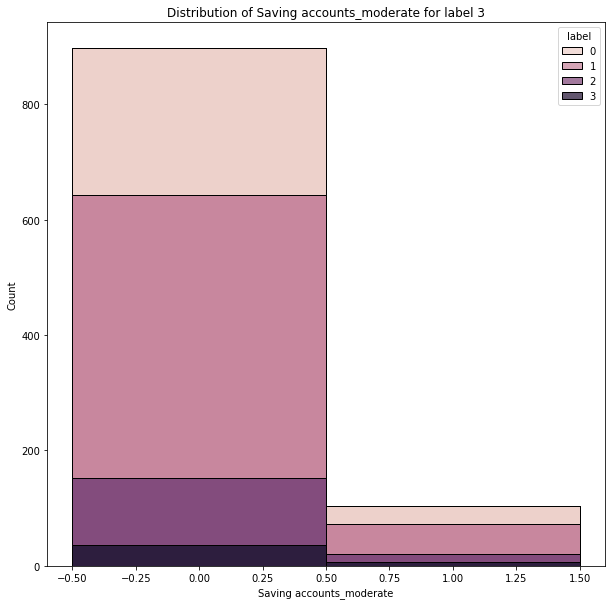

################################
Saving accounts_quite rich
################################


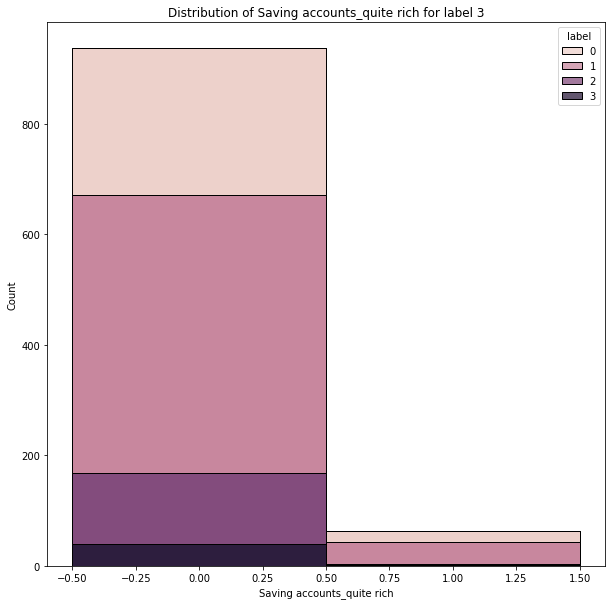

################################
Saving accounts_rich
################################


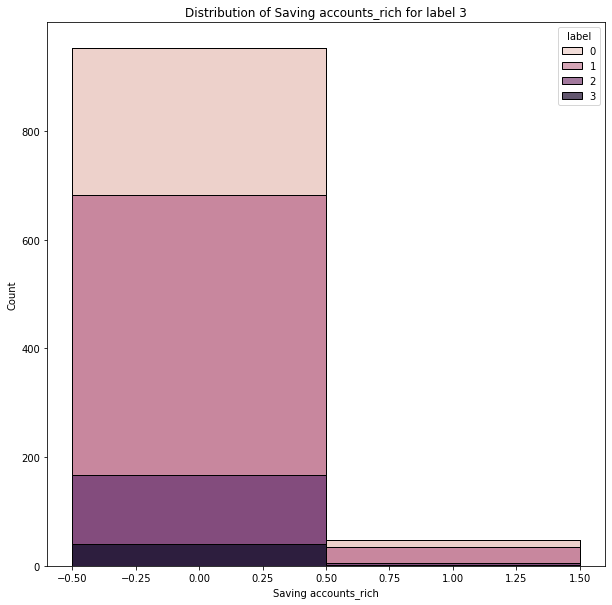

################################
Checking account_moderate
################################


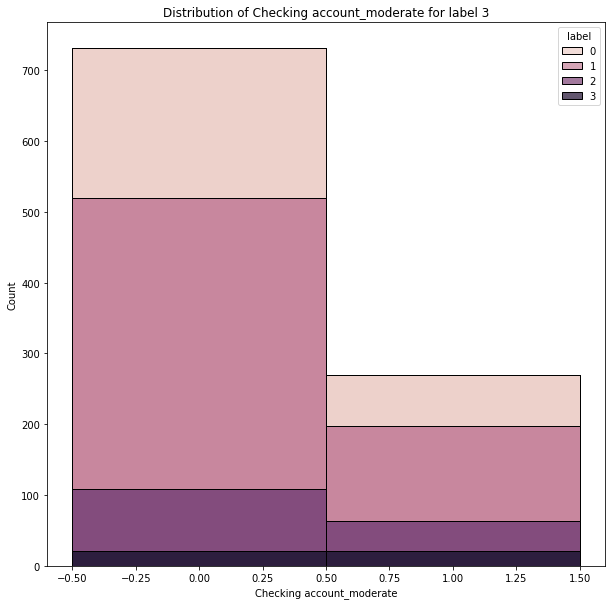

################################
Checking account_rich
################################


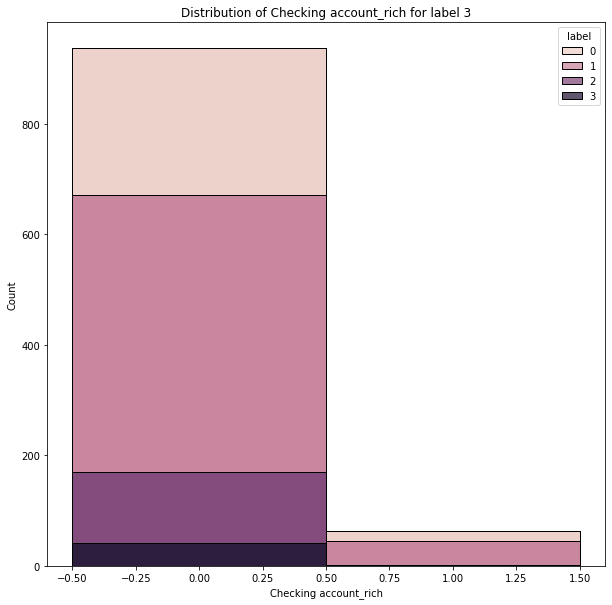

################################
Purpose_car
################################


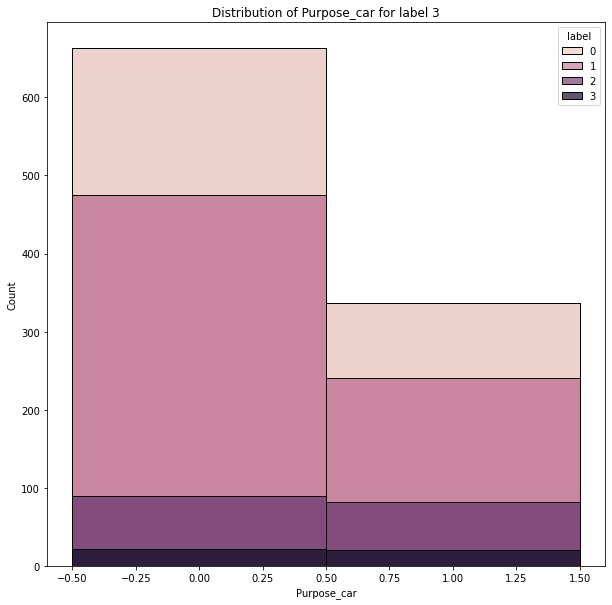

################################
Purpose_domestic appliances
################################


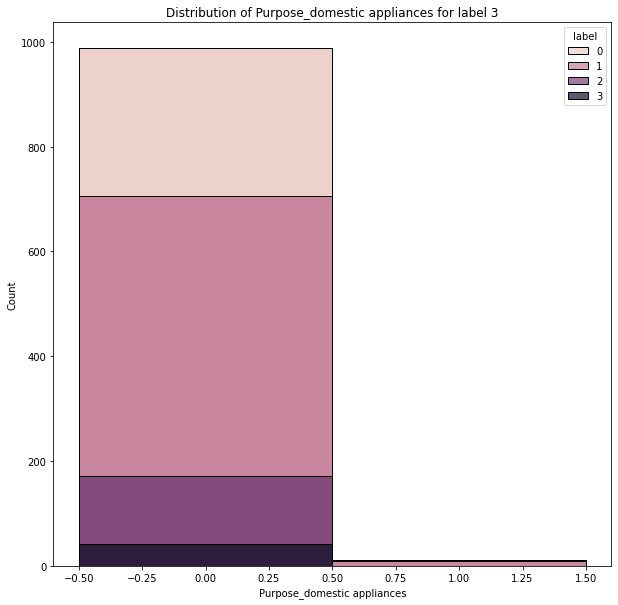

################################
Purpose_education
################################


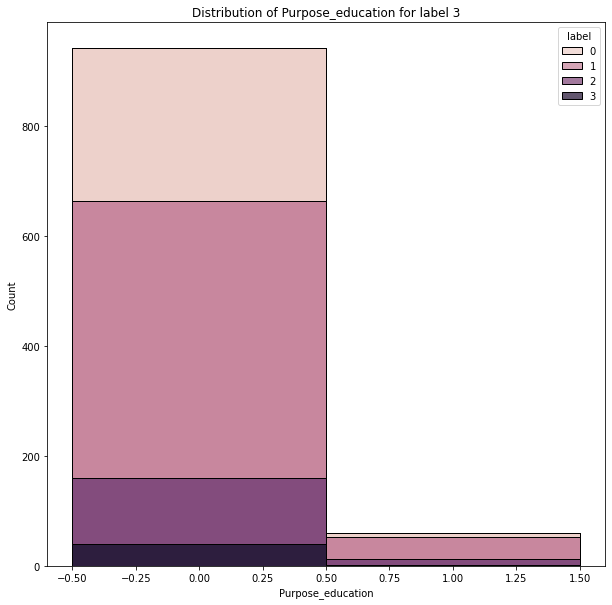

################################
Purpose_furniture/equipment
################################


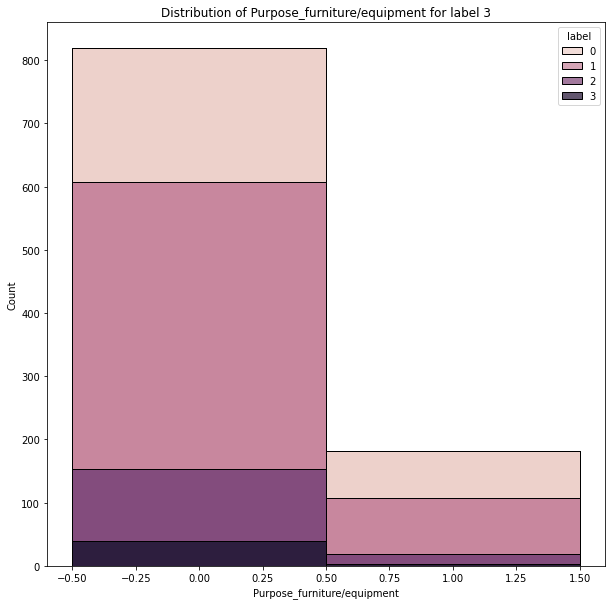

################################
Purpose_radio/TV
################################


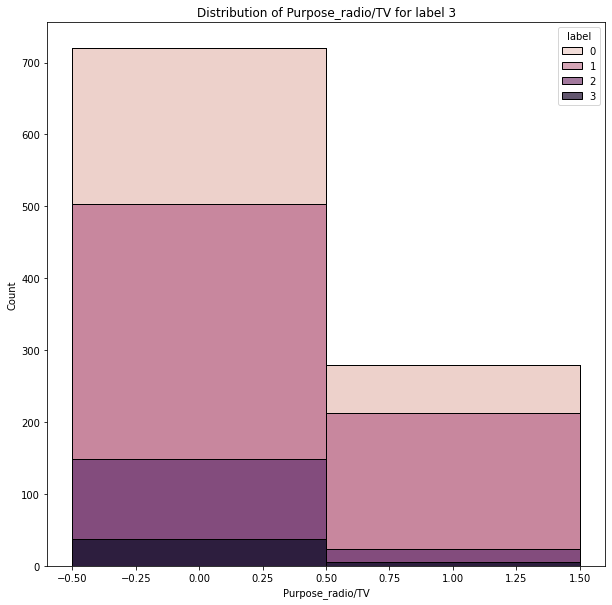

################################
Purpose_repairs
################################


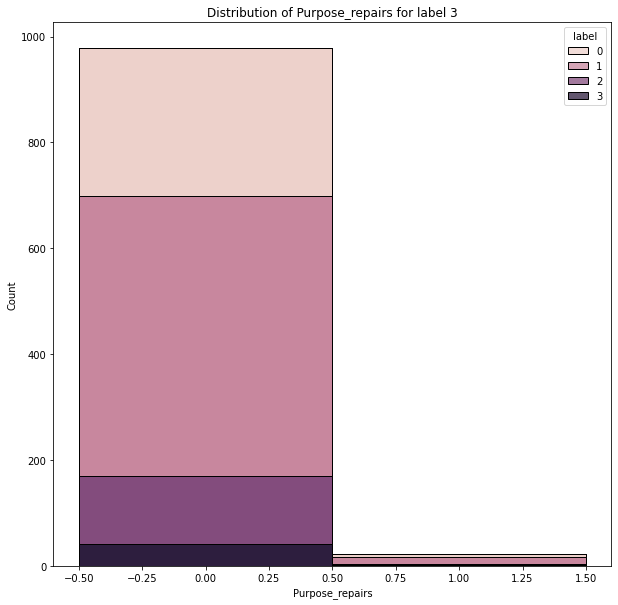

################################
Purpose_vacation/others
################################


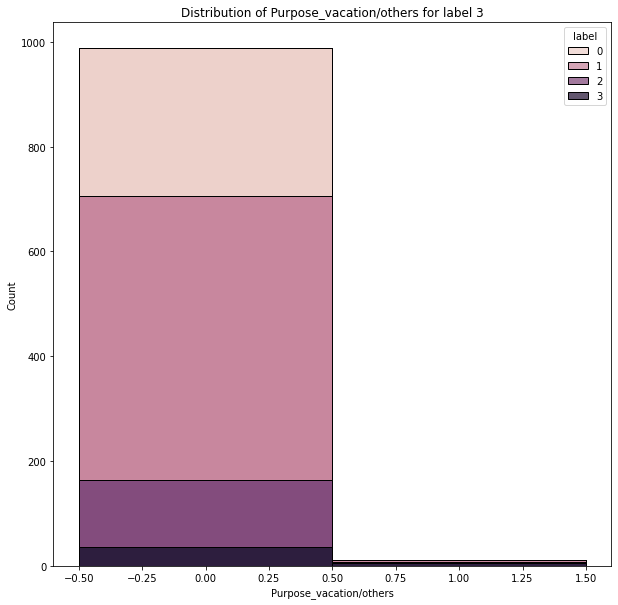

In [91]:
categorical_dummies = list(XX1.columns)
for to_rm in ["Age", "Credit amount", "Duration", "label"] :
  categorical_dummies.remove(to_rm)

centroid_visualizer(XX1, numerical = ["Age", "Credit amount", "Duration"], categorical = categorical_dummies)

# 2. PCA + MCA + KMEANS

In [92]:
X2_categorical = X[categorical]
X2_numerical = X[numerical]
X2_categorical.head()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose
0,male,2,own,NaN,little,radio/TV
1,female,2,own,little,moderate,radio/TV
2,male,1,own,little,NaN,education
3,male,2,free,little,little,furniture/equipment
4,male,2,free,little,little,car


In [93]:
X2_numerical.head()

,Credit amount,Age,Duration
0,1169,67,6
1,5951,22,48
2,2096,49,12
3,7882,45,42
4,4870,53,24


## PCA

We will add components such that the explained inertia is greater than 50%. Also the minimum allowed number of components is 2.

In [94]:
pca = prince.PCA(
    n_components=2,
    n_iter=50,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
    )
pca = pca.fit(X2_numerical)

No handles with labels found to put in legend.


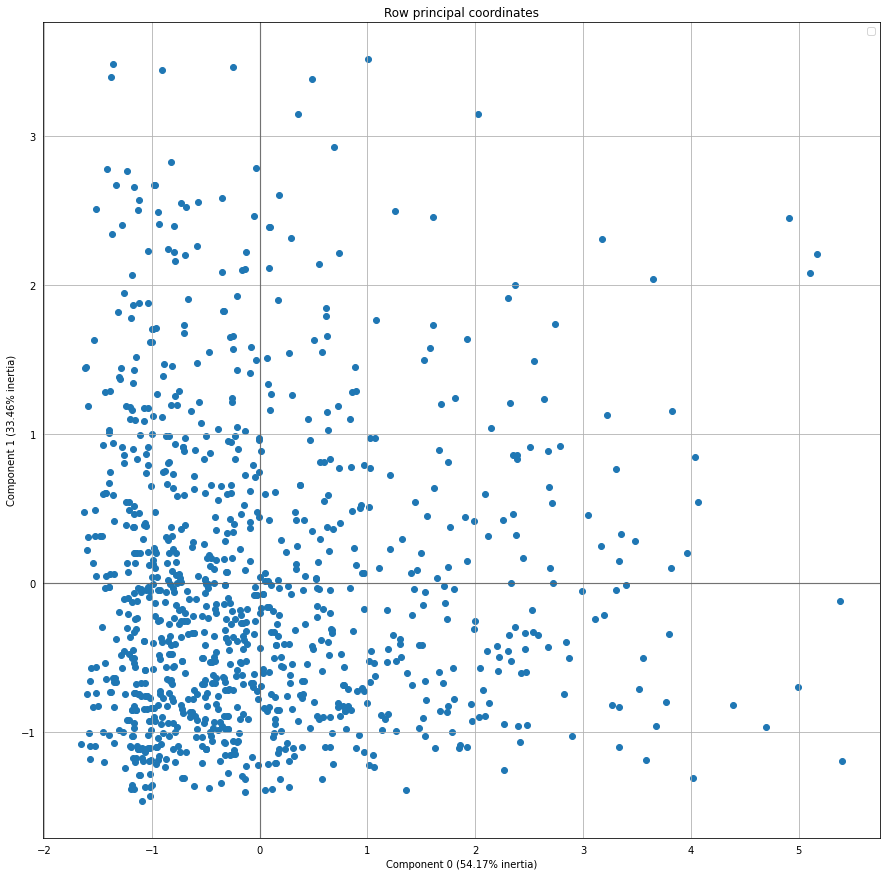

In [95]:
ax = pca.plot_row_coordinates(
    X2_numerical,
    ax=None,
    figsize=(15, 15),
    x_component=0,
    y_component=1,
    show_points=True
    )
show(ax)

We explained 80% of the total inertia with 2 axis for the numerical variable (which have 3 features). 

## MCA

In [96]:
mca = prince.MCA(
    n_components=2,
    n_iter=50,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42,
    )
mca = mca.fit(X2_categorical)

In [97]:
sum(mca.explained_inertia_)

0.1688422022657766

<Figure size 432x288 with 0 Axes>

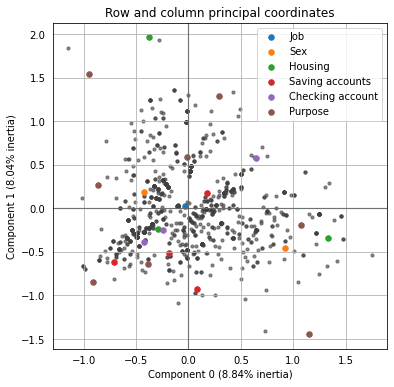

In [98]:
figure()

ax = mca.plot_coordinates(
        X = X2_categorical,
        ax=None,
        figsize=(6, 6),
        show_row_points=True,
        row_points_size=10,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=30,
        show_column_labels=False,
        legend_n_cols=1
        )

show(ax)

In [99]:
mca = prince.MCA(
    n_components=7,
    n_iter=50,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42,
    )
mca = mca.fit(X2_categorical)
sum(mca.explained_inertia_)

0.5190515305199035

## X preparation

In [100]:
X2_mca = mca.transform(X2_categorical)
X2_mca_names = list(X2_mca.columns)
for i in range(len(X2_mca_names)):
  X2_mca_names[i] = 'mca_' + str(X2_mca_names[i])
X2_mca.columns = X2_mca_names
X2_mca.head()

,mca_0,mca_1,mca_2,mca_3,mca_4,mca_5,mca_6
0,-0.180278,-0.025403,-0.545430,-0.149370,0.047833,-0.083540,-0.157980
1,-0.017427,-0.477343,-0.068812,0.148224,0.359003,-0.190186,-0.147259
2,-0.115041,0.639596,0.005981,0.827391,1.100156,-0.446819,-0.093425
3,0.316628,0.872488,-0.193345,-0.282516,0.034247,0.008843,-0.143278
4,-0.012652,1.122629,-0.008915,-0.094890,-0.324628,0.091382,0.010457


In [101]:
X2_pca = pca.transform(X2_numerical)
X2_pca_names = list(X2_pca.columns)
for i in range(len(X2_pca_names)):
  X2_pca_names[i] = 'pca_' + str(X2_pca_names[i])
X2_pca.columns = X2_pca_names
X2_pca.head()

,pca_0,pca_1
0,-1.411988,2.779563
1,2.266081,-1.249941
2,-0.821492,1.194185
3,2.390063,0.831963
4,0.576390,1.549696


In [102]:
X2 = X2_mca.copy()
X2['pca_0'] = X2_pca['pca_0']
X2['pca_1'] = X2_pca['pca_1']
X2.head()

,mca_0,mca_1,mca_2,mca_3,mca_4,mca_5,mca_6,pca_0,pca_1
0,-0.180278,-0.025403,-0.545430,-0.149370,0.047833,-0.083540,-0.157980,-1.411988,2.779563
1,-0.017427,-0.477343,-0.068812,0.148224,0.359003,-0.190186,-0.147259,2.266081,-1.249941
2,-0.115041,0.639596,0.005981,0.827391,1.100156,-0.446819,-0.093425,-0.821492,1.194185
3,0.316628,0.872488,-0.193345,-0.282516,0.034247,0.008843,-0.143278,2.390063,0.831963
4,-0.012652,1.122629,-0.008915,-0.094890,-0.324628,0.091382,0.010457,0.576390,1.549696


## k-means

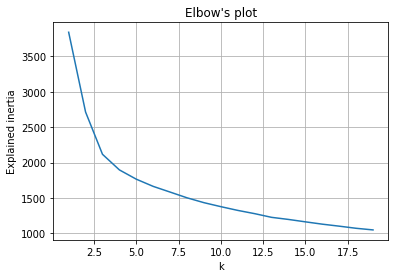

In [ ]:
elbow2 = Elbow(20)
elbow2.fit(X2)
elbow2.plot()

Something between 4 & 10 clusters?

Let's try with 4.

In [103]:
kmeans2 = KMeans(n_clusters = 4, max_iter = 1000, n_init = 50, init = 'k-means++').fit(X2)

Once again, let's plot in 2d the results, with the use of  pca.

<Figure size 432x288 with 0 Axes>

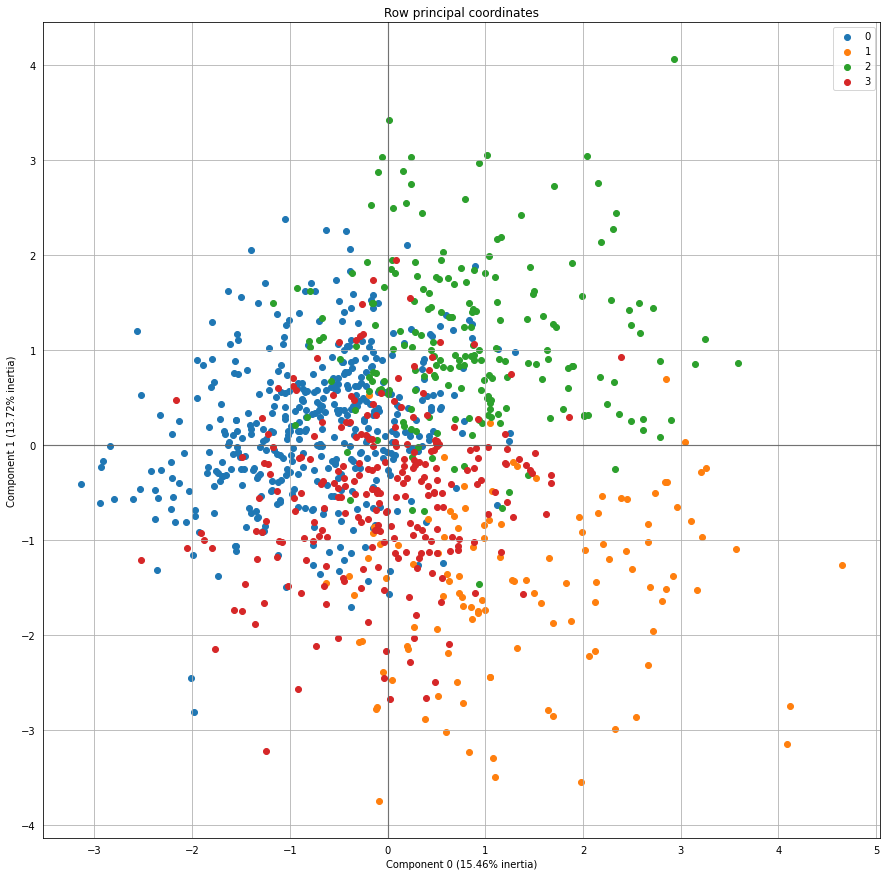

In [108]:
y2 = kmeans2.predict(X2)
visualizer.fit(X2)
visualizer.plot_2d(y2)

The plot in 2d seems smoother than the 2d-plot from part 1. But it is complicated to truely know if the clustering is smoother at this point. 

## Centroids

Because of the PCA, we lost a lot of interpretability for the centroids. We performed a PCA on numerical variables and another PCA on the contingency table associated to the categorical variables. 

To try to interprate the centroids we should apply reversed PCA and anzlyze the contingency table (and even that way we would have loose information).

I suggest to plot the centroids and boxplots for coordinates in the PCA base (to see how the distances have been computed).

No handles with labels found to put in legend.


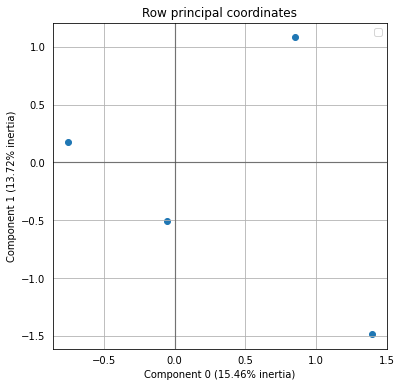

In [109]:
visualizer.plot_centers(kmeans2.cluster_centers_)

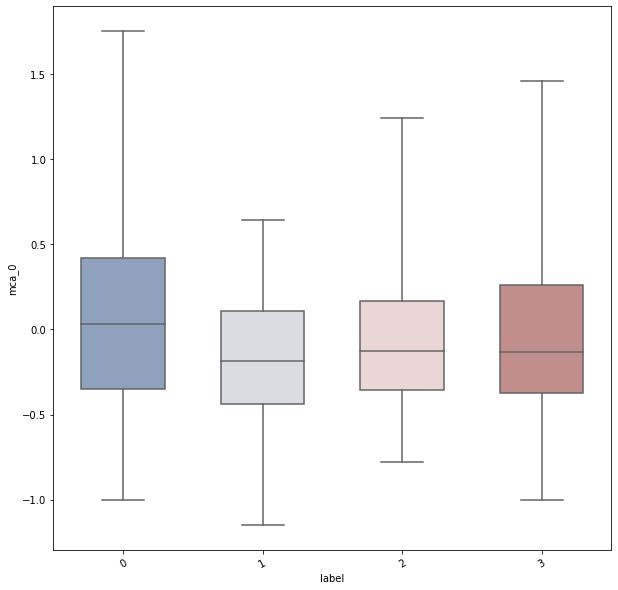

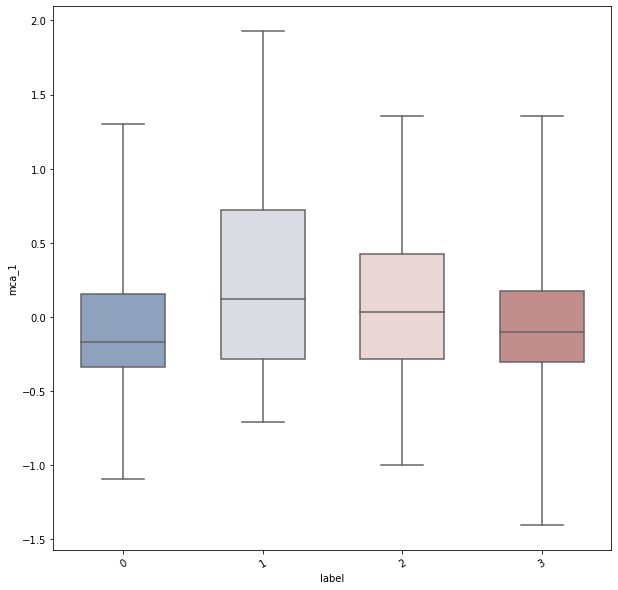

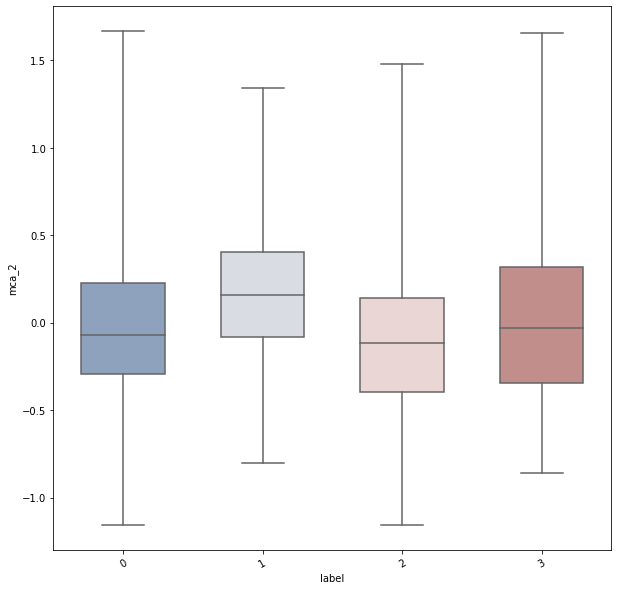

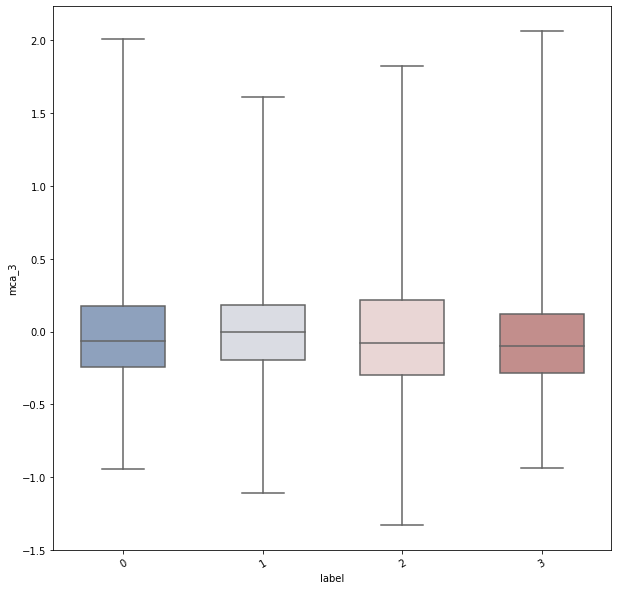

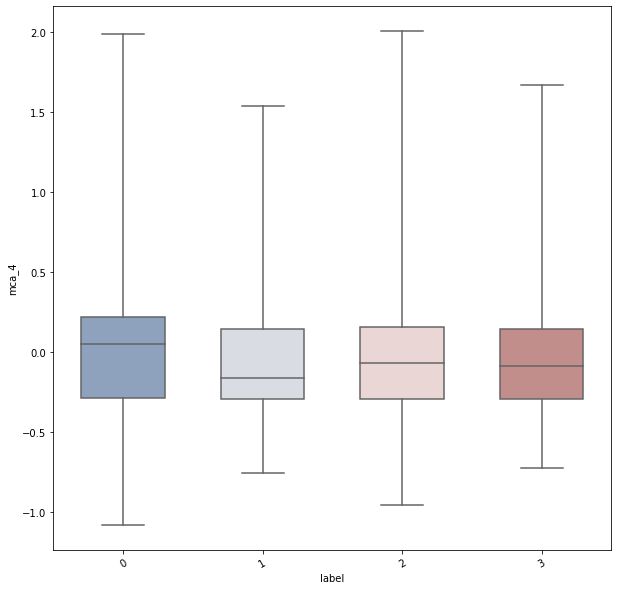

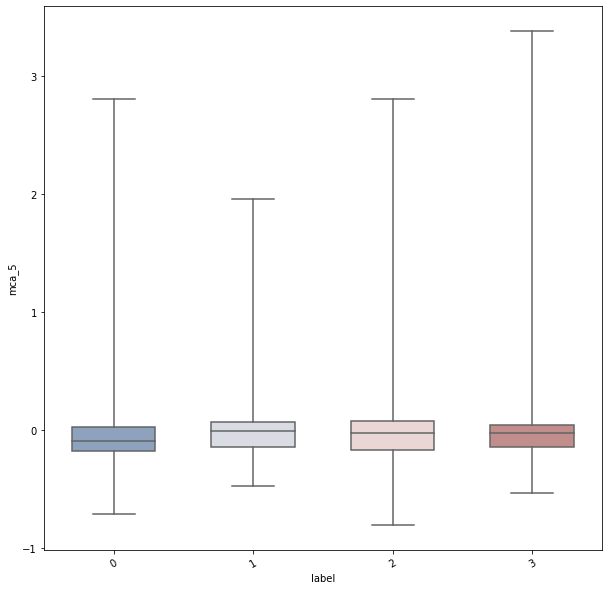

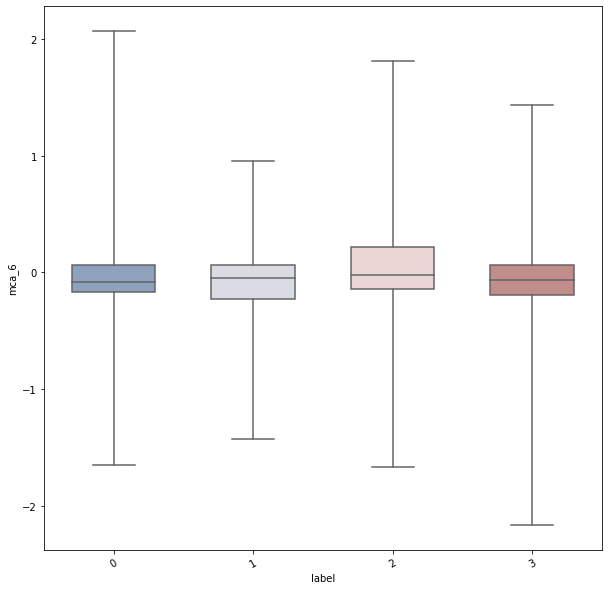

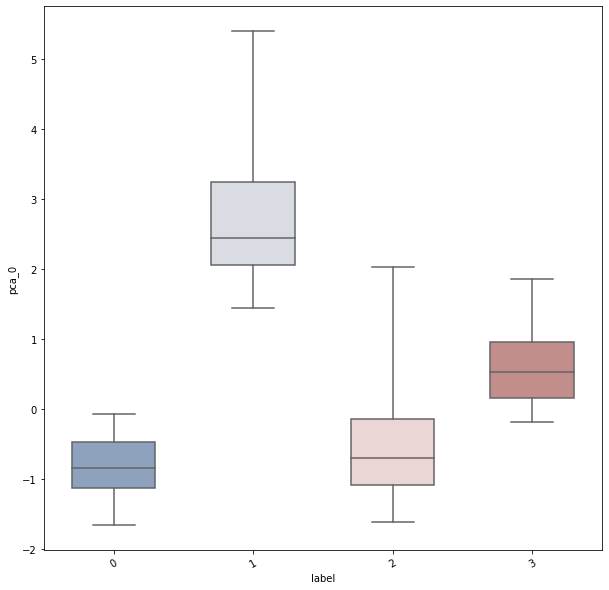

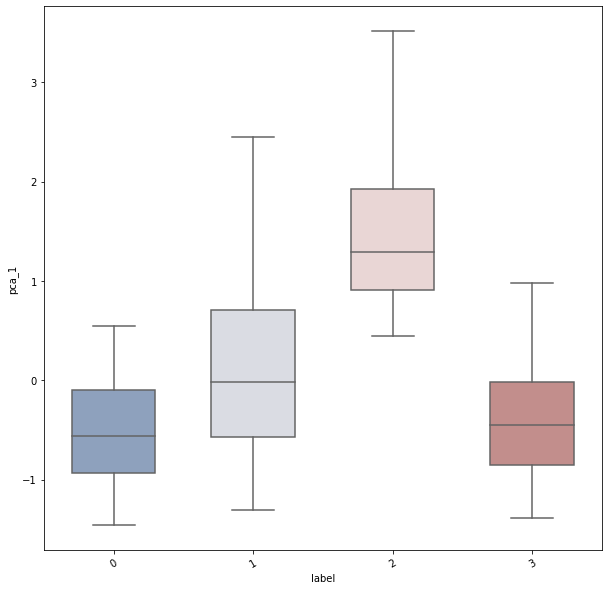

In [107]:
XX2 = X2.copy()

XX2['label'] = kmeans2.predict(XX2)
numerical_tmp = list(XX2.columns)
numerical_tmp.remove('label')

centroid_visualizer(XX2, numerical = numerical_tmp)

An interesting fact is the following : 

Because of a PCA property, the first factorial axis have more information than the second one etc.

So, the differences between distributions ~ label are very important for MCA_0 and PCA_0 but PCA_1 & MCA_6 are not very interesting.

# 3. FAMD + KMEANS

## FAMD

In [110]:
famd = prince.FAMD(
      n_components=2,
      n_iter=3,
      copy=True,
      check_input=True,
      engine='auto',
      random_state=42
      )

famd.fit(X)

FAMD(check_input=True, copy=True, engine='auto', n_components=2, n_iter=3,
     random_state=42)

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

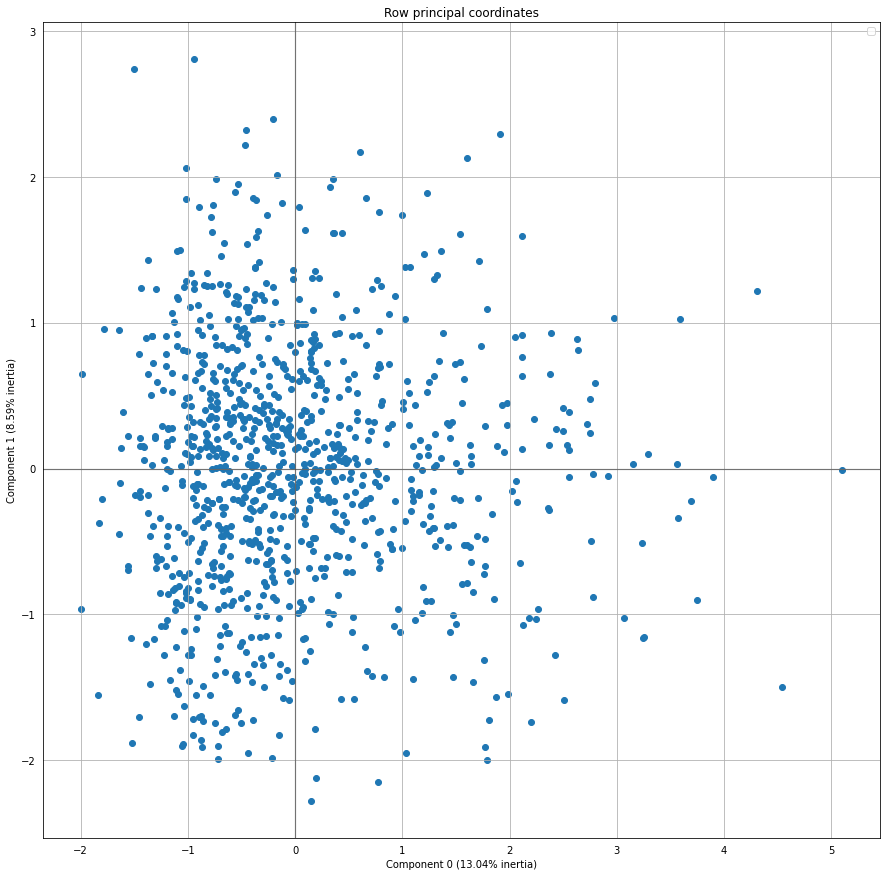

In [111]:
figure( )

ax = famd.plot_row_coordinates(
          X,
          ax=None,
          figsize=(15, 15),
          x_component=0,
          y_component=1,
          show_points=True
          )

show(ax)

In [112]:
famd = prince.FAMD(
      n_components=7,
      n_iter=3,
      copy=True,
      check_input=True,
      engine='auto',
      random_state=42
      ).fit(X)

print(sum(famd.explained_inertia_))

X3 = famd.transform(X)

0.5027026004554996


## k-means

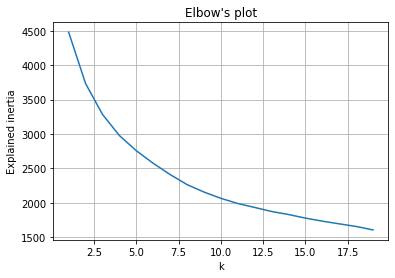

In [ ]:
elbow3 = Elbow(20)
elbow3.fit(X3)
elbow3.plot()

Something between 4 & 15 clusters (when the Elbow's plot is that smooth, it is not easy to choose a number of clusters).

Let's try with 4

In [113]:
kmeans3 = KMeans(n_clusters = 4, max_iter = 1000, n_init = 50, init = 'k-means++').fit(X3)

<Figure size 432x288 with 0 Axes>

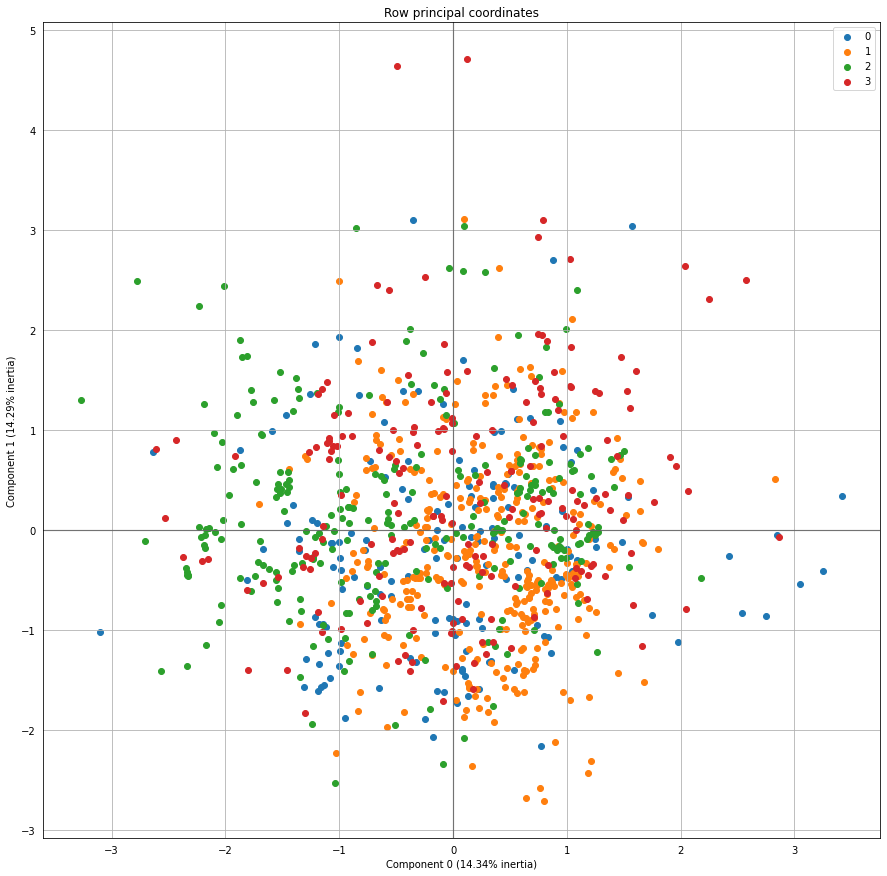

In [114]:
y3 = kmeans3.predict(X3)
visualizer.fit(X3)
visualizer.plot_2d(y3)

## Centroids

We have the same interpretability problem as in the previous part.

We'll just try to visualize the cluster centers and the importance of PCA-projected variables on the clustring.

If we wanna give a sense, we could perform reverse PCA or give information like " The first principal component of FAMD seems really discriminant for the choice of cluster. The variable x has a weight of p in the creation of this principal component ". If x and p are large (compared to 1 or other x and p) it is relevent to say that the variations of x have a big weight in the creation of its cluster center.

No handles with labels found to put in legend.


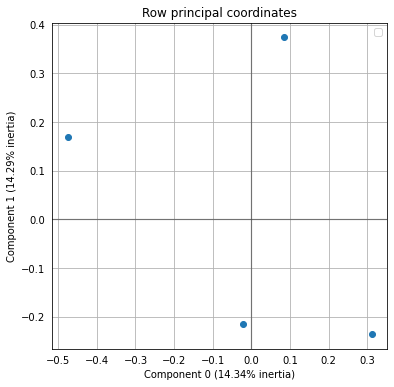

In [115]:
visualizer.plot_centers(kmeans3.cluster_centers_)

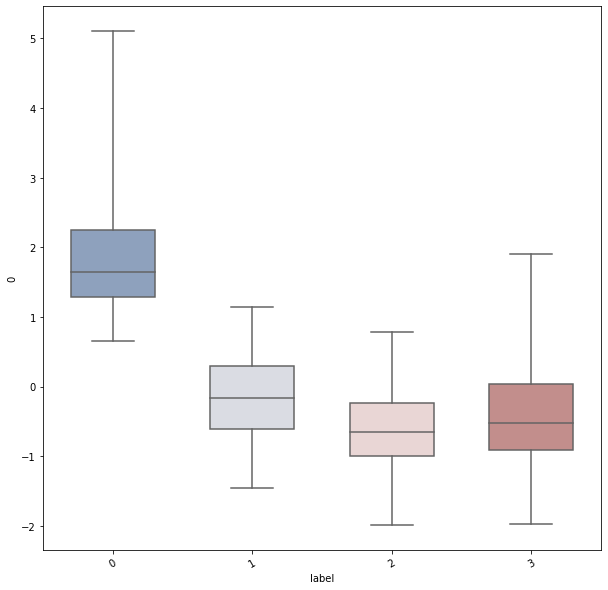

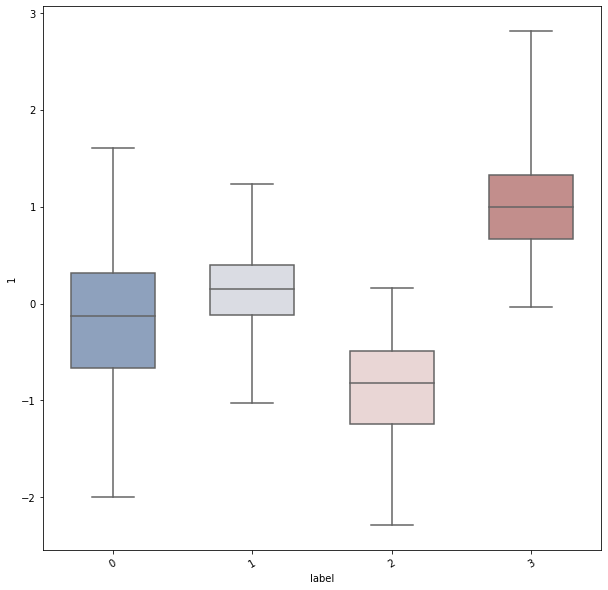

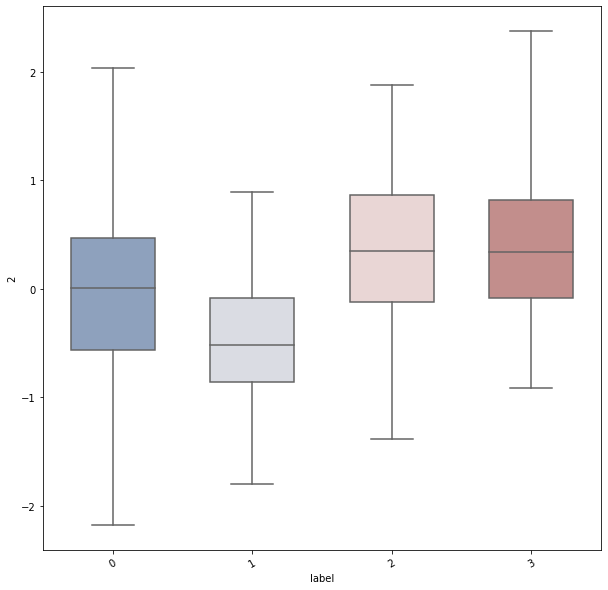

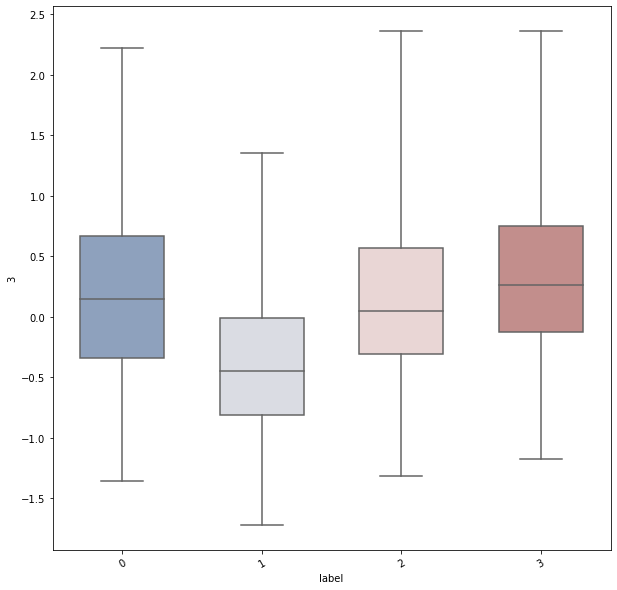

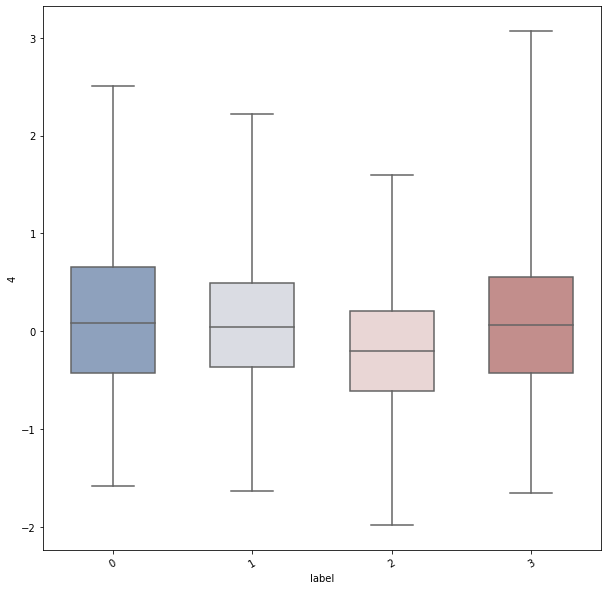

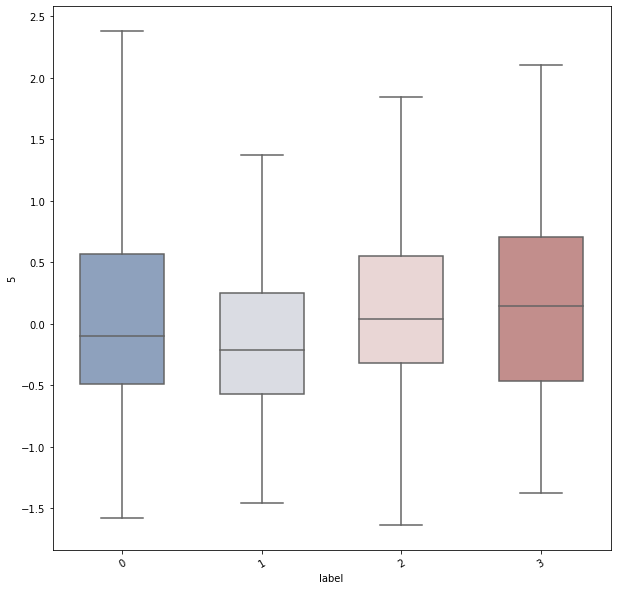

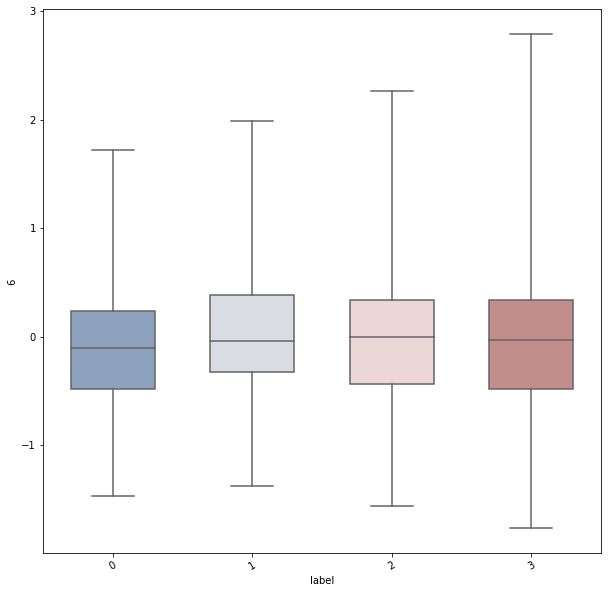

In [118]:
XX3 = X3.copy()
XX3["label"] = kmeans3.predict(XX3)
tmp_numerical = list(XX3.columns)
tmp_numerical.remove("label")

centroid_visualizer(XX3, numerical = tmp_numerical)

# 4. K-PROTOTYPES

In this part we will try a clustering with both numerical & categorical data without engineering.

See examples and some mathematical elements here :

https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

In [173]:
X4 = X.copy()
X4[numerical] = X4[numerical].fillna("mean")
X4[categorical] = X4[categorical].fillna("mode")
X4["Job"] = X4["Job"].apply(str)
X4.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

In [174]:
catColumnsPos = [X4.columns.get_loc(col) for col in list(X4.select_dtypes('object').columns)]

catColumnsPos

[1, 2, 3, 4, 5, 8]

In [159]:
#### Code snipped from previous link


# Choose optimal K using Elbow method
cost = []

for cluster in range(1, 10):
    kprototype = KPrototypes(n_jobs = 4, n_clusters = cluster, init = 'Huang', random_state = 0)
    kprototype.fit_predict(X4.values, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(cluster))

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


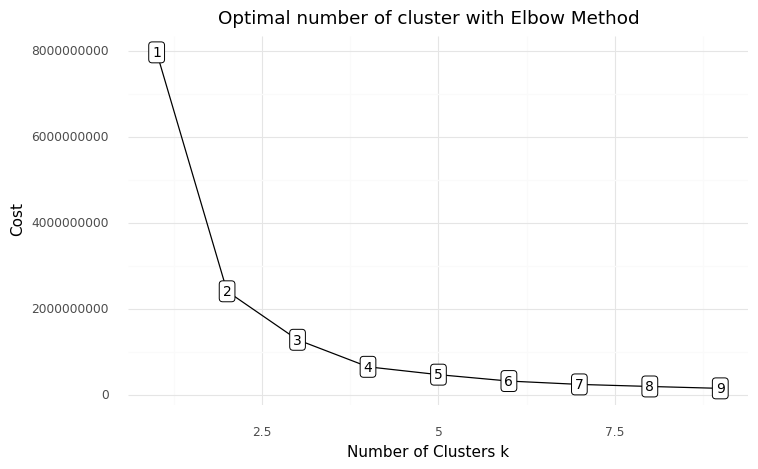

<ggplot: (8771165571061)>

In [ ]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [175]:
kprototype = KPrototypes(n_jobs = 4, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit(X4.values, categorical = catColumnsPos)
y4 = kprototype.predict(X4.values, categorical = catColumnsPos)

<Figure size 432x288 with 0 Axes>

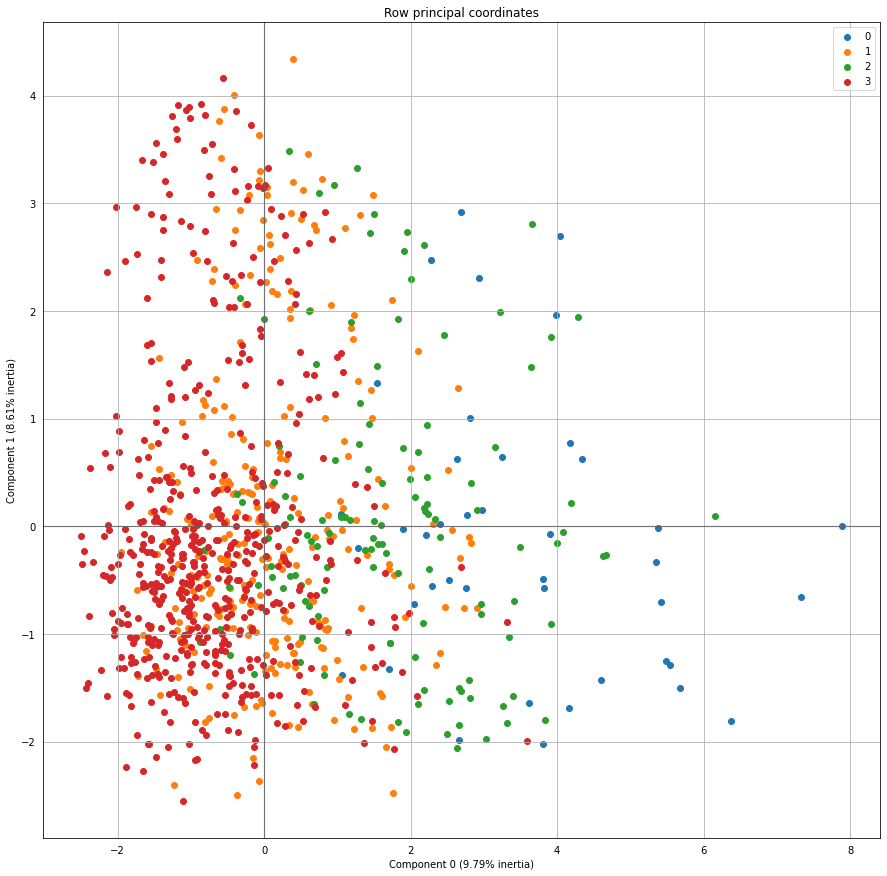

In [176]:
XX4 = pd.get_dummies(data = X4, columns = categorical, drop_first = True)
visualizer.fit(XX4.values)
visualizer.plot_2d(y4)

The k-prototype seems really smooth, even after the pca for plotting, and even if the data used for representation (after the get_dummies) is not the data used for the algorithm.

## Centroids

In [177]:
centers4 = pd.DataFrame(kprototype.cluster_centroids_)
centers4.columns = X4.columns
centers4

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,36.666666666666664,12511.714285714286,40.26190476190476,male,3,own,little,moderate,car
1,34.67368421052632,3583.5894736842106,23.50526315789474,male,2,own,little,mode,car
2,36.8,7127.523076923077,33.34615384615385,male,2,own,little,mode,car
3,35.61694290976059,1469.364640883978,15.060773480662984,male,2,own,little,mode,radio/TV


Here, we did not reduce the dimension, and we did not use any label encoding (it is hidden in the k-prototypes algorithm), so the centroids have a top interpretability.

For numerical variables, the center' values are the cluster means, for numerical variables, we got the mode inside the cluster.

For most of numerical values the modes are the same (but maybe the distributions are different). Let's see.

In [179]:
XXX4 = X4.copy()
XXX4['label'] = kprototype.predict(XXX4.values, categorical = catColumnsPos)

XXX4.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,label
0,67,male,2,own,mode,little,1169,6,radio/TV,3
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,mode,2096,12,education,3
3,45,male,2,free,little,little,7882,42,furniture/equipment,2
4,53,male,2,free,little,little,4870,24,car,1


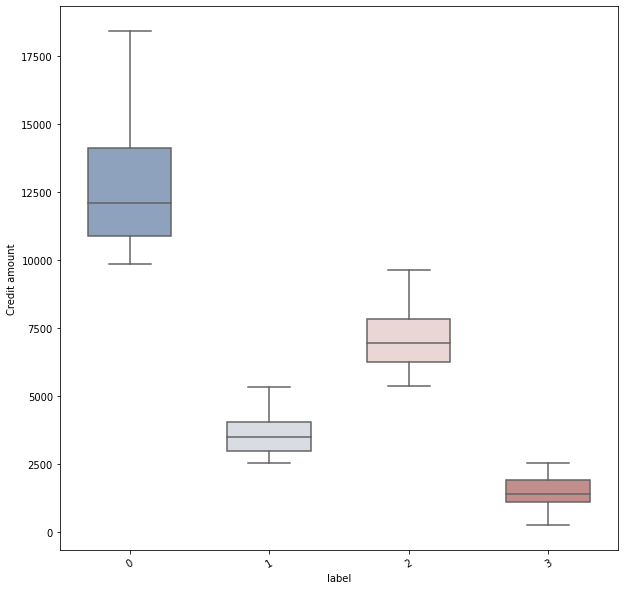

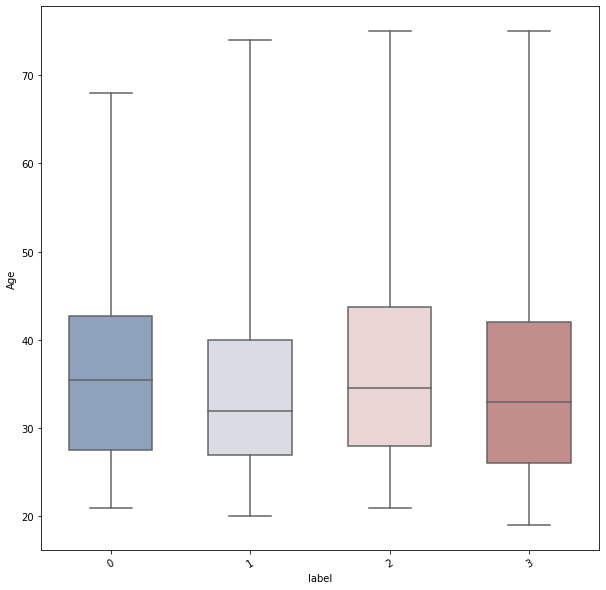

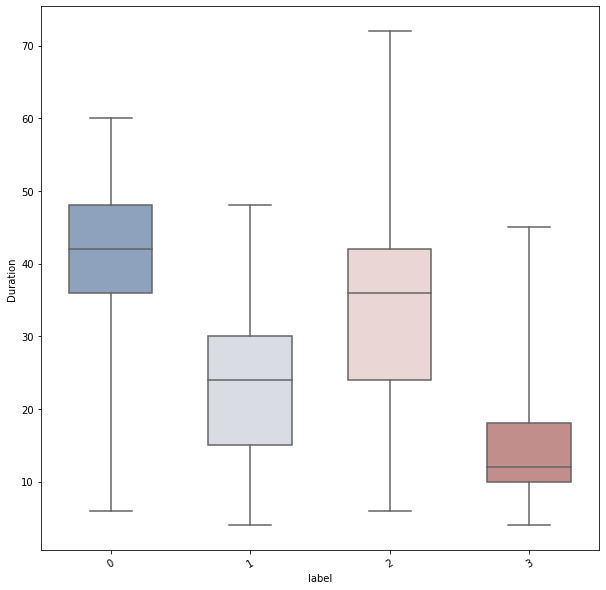

################################
Sex
################################


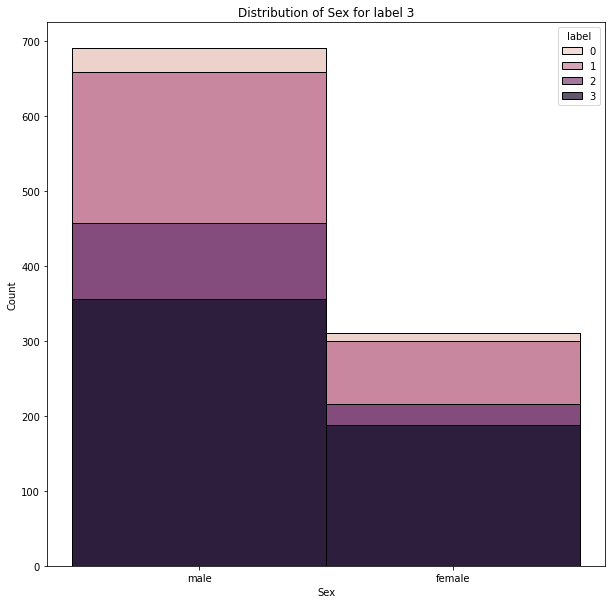

################################
Job
################################


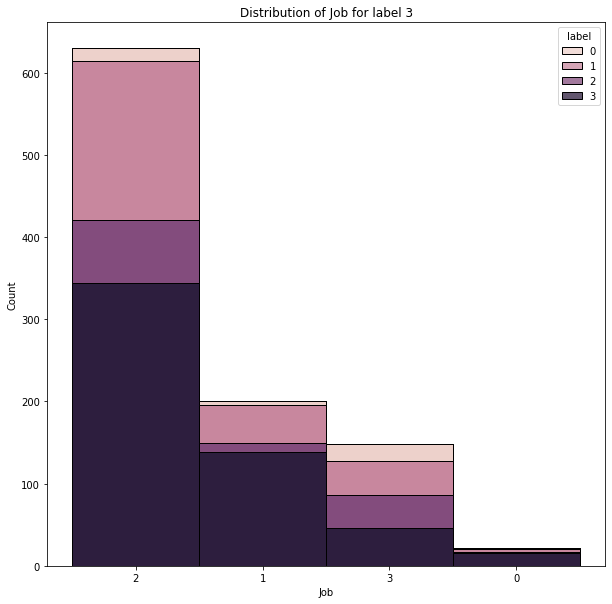

################################
Housing
################################


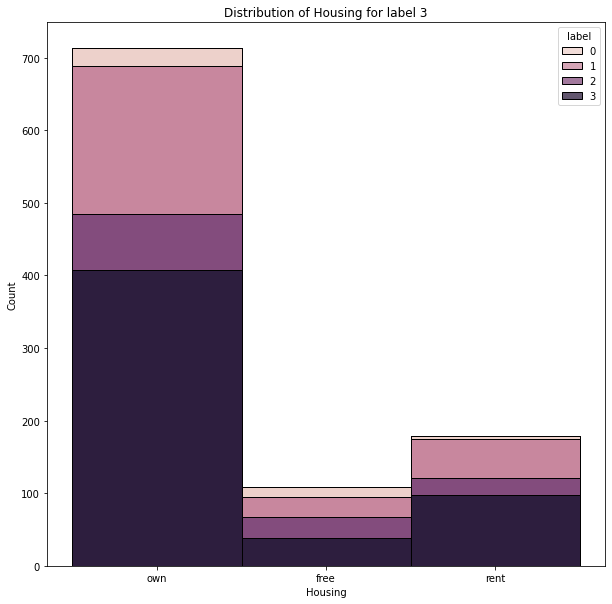

################################
Saving accounts
################################


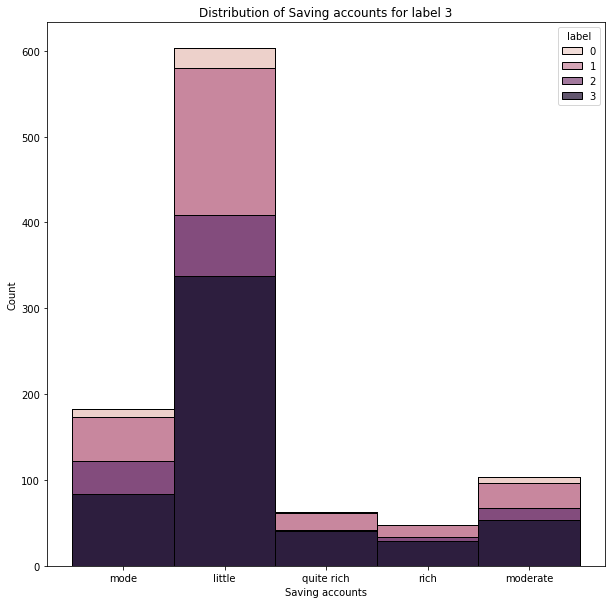

################################
Checking account
################################


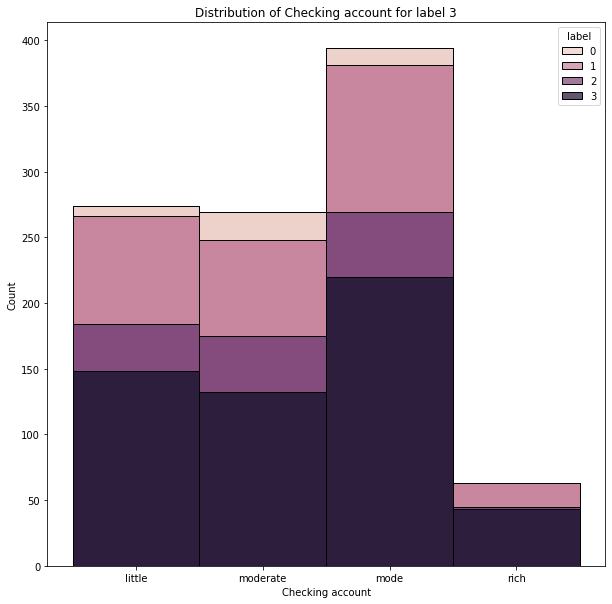

################################
Purpose
################################


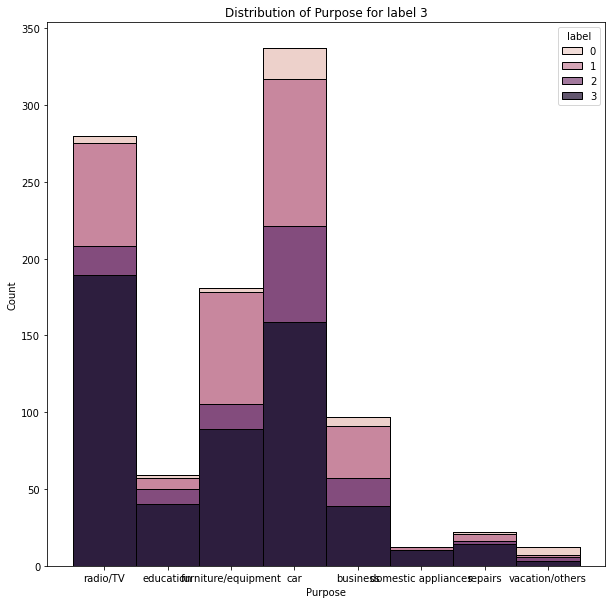

In [167]:
centroid_visualizer(XXX4, numerical = numerical, categorical = categorical)

# 5. Ananlyzis

We applied 4 clustering methods ( k-means with 3 different inputs and k - prototypes). The comparison of these methods is not easy:

- Because there is no true variable to predict there is no way to assess our accuracy (or another quality measurement)

- Our plots are not very meaningful because of PCAs. So we can't tell wether data is well-separated or not.

I am not so sure about the math, but I guess that one way of smoothness measurement would be to apply a supervised learning method with as target the cluster label. Because we don't want our model to be dependant from parameters, we will apply k-NN. It's strange because we do not want to assess the quality of the perdictor but the quality of the predictions.

I found a reference there :

https://www.bing.com/search?form=MOZLBR&pc=MOZD&q=compare+smoothness+of+clusterings

But there is not much details...

My intuition is that a clustering is smooth if :
- points within a cluster are close
- points in different clusters are distant

With the k-nn we find for any point its k nearest neighbors and if they belong to the same cluster, our model is smooth, if it fails clusters have not enough margin between each other.

We have fixed 4 clusters for any of the clusting method.

In [180]:
y_trains = [y1, y2, y3, y4]
X_trains = [X1, X2, X3, XX4]

In [181]:
i = 1

for X_train, y_train in zip( X_trains, y_trains ):

  tmp_model = KNeighborsClassifier(8, n_jobs = 5)
  tmp_model.fit(X_train, y_train)
  accuracy = accuracy_score(y_train, tmp_model.predict(X_train)) 

  print('Case ', i)
  print('score :', accuracy)
  print("_____________________________")
  i+=1

Case  1
score : 0.998
_____________________________
Case  2
score : 0.948
_____________________________
Case  3
score : 0.935
_____________________________
Case  4
score : 0.997
_____________________________


The most powerful method is the k - protoypes, according to our assessment. Noneless, our method is sensitive to k for the k-nn (which has been fixed arbitrary to 8).

Also we got no prior for our clustering. With known datasetes, with a true y_train to compare to our clusters ; the signal treatment through PCA could have increased our ability to predict.

# Bonus : k-means initialization

Just to illustrate the point, let's try method 1 (get_dummies + k-means) with small parameters.

In [23]:
kmeans_11 = KMeans(n_clusters = 2, 
                   init = 'random', 
                   n_init = 1,
                   max_iter = 5,
                   precompute_distances = False,
                   random_state = 18)

kmeans_11.fit(X1)
y11 = kmeans_11.predict(X1)

In [24]:
kmeans_12 = KMeans(n_clusters = 2, 
                   init = 'random', 
                   n_init = 1,
                   max_iter = 5,
                   precompute_distances = False,
                   random_state = 45)

kmeans_12.fit(X1)
y12 = kmeans_12.predict(X1)

<Figure size 432x288 with 0 Axes>

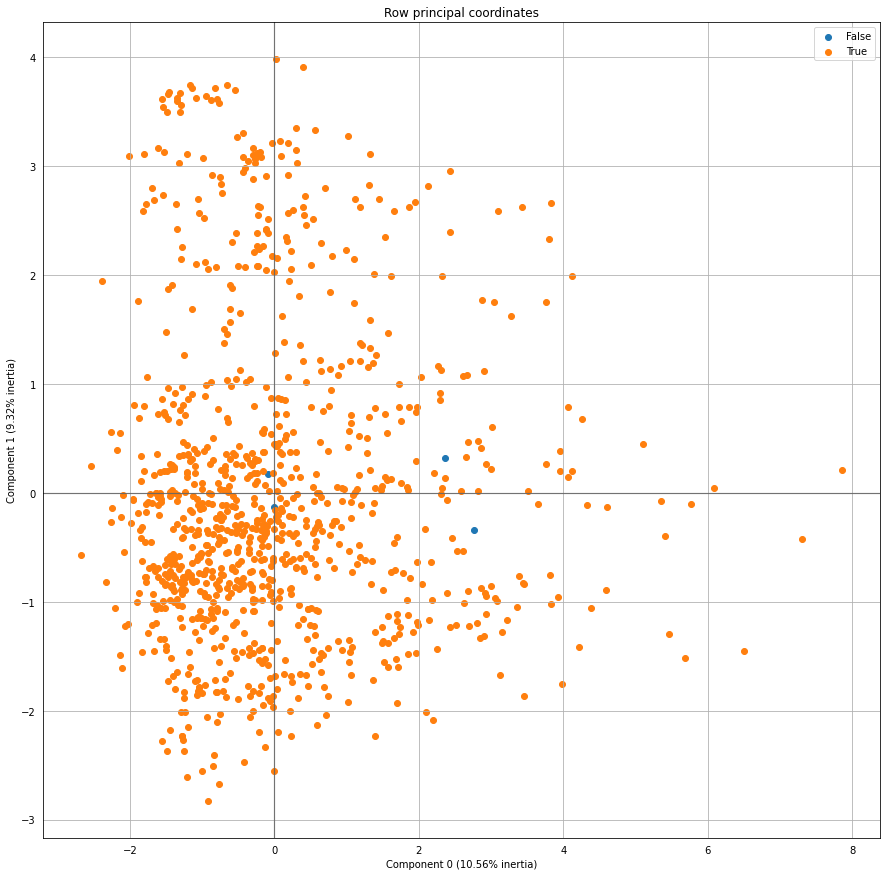

In [25]:
y_comp = (y12 == y11)
visualizer.fit(X1)
visualizer.plot_2d(y_comp)

Remember that cluster labels are arbitrary. So the less represented color might be the points classified in different ways

No handles with labels found to put in legend.


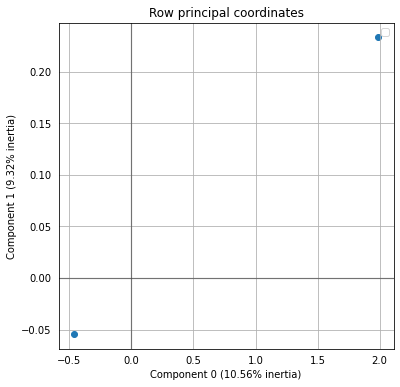

No handles with labels found to put in legend.


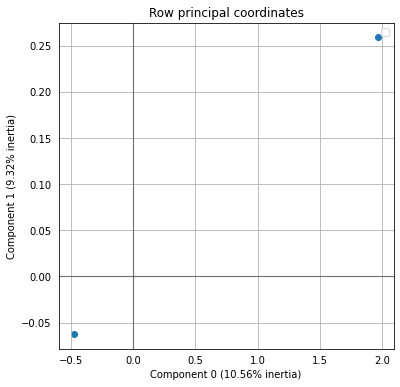

In [26]:
center_11 = kmeans_11.cluster_centers_
center_12 = kmeans_12.cluster_centers_

pca = prince.PCA(
    n_components=2,
    n_iter=50,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
    )

pca = pca.fit(X1)


ax1 = pca.plot_row_coordinates(
    center_11,
    ax=None,
    x_component=0,
    y_component=1,
    show_points=True
    )
show(ax1)

ax2 = pca.plot_row_coordinates(
    center_12,
    ax=None,
    x_component=0,
    y_component=1,
    show_points=True
    )
show(ax2)


The clusters are not exactly the same (the the top point).
But with only 20 iterations they are already close.

To avoid the problems related to initialization of this random method, several things are implemented and there are some consistency results.

- The k-means algorithm is **convergent**. That means that with a # of iterations large enough the method will converge and give the same centroids (if there is not much seal points).

- scikit learn always tests the main algorithm more than one time with different initializations (and take the best created centroids in term of distance). It avoids seal points previously mentionned.

- "burn-in". In practice, scikit learn does not initialize randomly but applies a first stochastic optimization algorithm in order to initialize not too far from the best centroids.